The logistic regression classifier uses the shape properties and pixel brightness from the satellite imagery to assign a probability that a segmented region is an ice floe. To train the logistic regression classifier, we require a balanced set of true positives and false positives. 

Identifying true positives
- tracked
- circularity > 0.6
- net displacement > 1 km / day?

False positives
- circularity < 0.4
- sea ice concentration = 0



In [14]:
import os
import numpy as np
import pandas as pd
import pyproj
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from skimage.measure import regionprops_table
import sys
import warnings
import xarray as xr

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

# Adding average pixel brightness to segments

In [34]:
# Data is stored on the shared drive
dataloc = '/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/'

def get_month_folder(date):
    """Simple utility for navigating file structure"""
    start = '{y}{m}01'.format(y=date.year,
                              m=str(date.month).zfill(2))
    end = '{y}{m}01'.format(y=date.year,
                              m=str(date.month + 1).zfill(2))
    if (date.month == 3) | (date.month == 4):
        start = '{y}0331'.format(y=date.year)
        end = '{y}0501'.format(y=date.year)
    
    return '-'.join(['fram_strait', start, end])

#### Specify locations for data.
# External datasets not included in archive are stored in a lower 
year = 2017
ift_loc = '../data/all_floes/' # Output from the interpolate ift file

#### Load ift data
ift_df = pd.read_csv(ift_loc + 'ift_floe_properties_{y}.csv'.format(y=year), index_col=0)
ift_df['datetime'] = pd.to_datetime(ift_df.datetime.values)

In [ ]:
%%time
dfs_with_pixel_data = []
for date, group in ift_df.groupby('datetime'):
    year_folder = 'fram_strait-{y}'.format(y=date.year)
    lb_path = os.path.join(dataloc, year_folder, get_month_folder(date), 'labeled_raw',
                              '.'.join([date.strftime('%Y%m%d'), group.satellite.values[0], 'labeled_raw', '250m', 'tiff']))
    tc_path = os.path.join(dataloc, year_folder, get_month_folder(date), 'truecolor',
                              '.'.join([date.strftime('%Y%m%d'), group.satellite.values[0], 'truecolor', '250m', 'tiff']))
    fc_path = os.path.join(dataloc, year_folder, get_month_folder(date), 'falsecolor',
                              '.'.join([date.strftime('%Y%m%d'), group.satellite.values[0], 'falsecolor', '250m', 'tiff']))
    with rio.open(lb_path) as im:
        lb_im = reshape_as_image(im.read())
    with rio.open(tc_path) as im:
        tc_im = reshape_as_image(im.read())
    with rio.open(fc_path) as im:
        fc_im = reshape_as_image(im.read())
        
    props_tc = pd.DataFrame(regionprops_table(lb_im[:, :, 0], tc_im, properties=['label', 'area', 'perimeter', 'solidity', 'intensity_mean']))
    props_fc = pd.DataFrame(regionprops_table(lb_im[:, :, 0], fc_im, properties=['label', 'intensity_mean']))
    props_tc.rename({'intensity_mean-0': 'tc_channel0',
                     'intensity_mean-1': 'tc_channel1',
                     'intensity_mean-2': 'tc_channel2',
                     'area': 'area_sk',
                     'perimeter': 'perimeter_sk'}, axis=1, inplace=True)
    props_fc.rename({'intensity_mean-0': 'fc_channel0',
                     'intensity_mean-1': 'fc_channel1',
                     'intensity_mean-2': 'fc_channel2'}, axis=1, inplace=True)
    
    props = props_tc.merge(props_fc, left_on='label', right_on='label')
    props['circularity'] = 4*np.pi*props['area_sk']/props['perimeter_sk']**2
    dfs_with_pixel_data.append(group.merge(props, left_on='orig_idx', right_on='label'))

    del lb_im, tc_im, fc_im, props_tc, props_fc, props

In [44]:
for name, group in ift_df.groupby(ift_df.datetime.dt.date):
    
    break

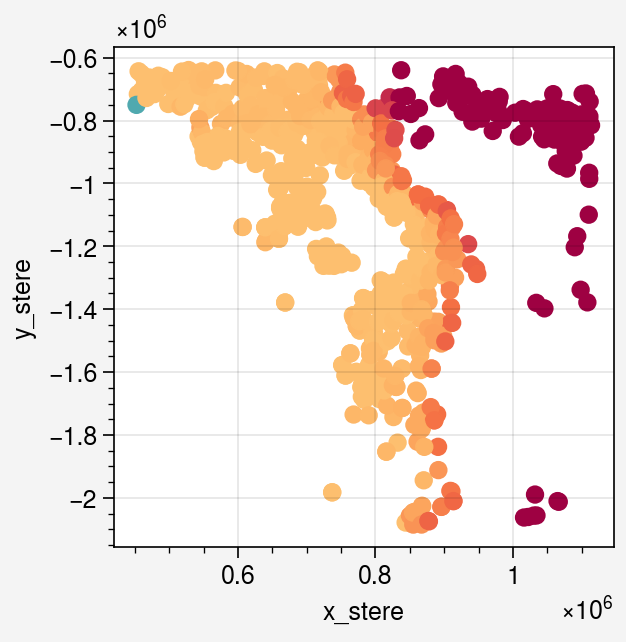

In [45]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.scatter(group.x_stere, group.y_stere, c=group.nsidc_sic, vmin=0, vmax=3, cmap='spectral')

(array([ 3.,  1., 10., 19., 16., 16., 15., 12.,  9.,  5.]),
 array([0.1273973 , 0.2095905 , 0.29178369, 0.37397689, 0.45617009,
        0.53836329, 0.62055649, 0.70274969, 0.78494289, 0.86713609,
        0.94932928]),
 <BarContainer object of 10 artists>)

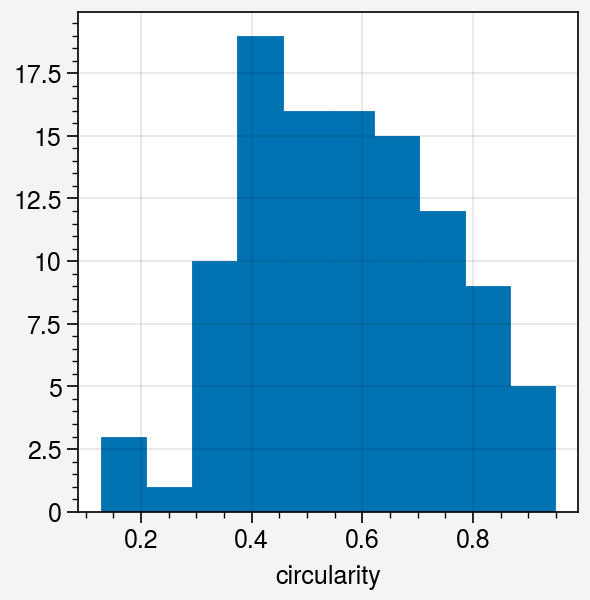

In [56]:
group['circularity'] = 4*np.pi*group['area']/(group['perimeter']**2)
fig, ax = pplt.subplots()
ax.hist(group.loc[group['nsidc_sic'] == 0].circularity)

In [ ]:
variables = ['circularity', # 'solidity',
             'tc_channel0',
#              'tc_channel1', 'tc_channel2',
             'fc_channel0', 'fc_channel1', 'fc_channel2']
# Scale the pixel brightness from 0 to 1
data_scaled = data.copy()
for var in variables:
    if ('tc' in var) | ('fc' in var):
        data_scaled[var] = data_scaled[var]/255
X = data_scaled.loc[:, variables].to_numpy()
y = data_scaled['TP'].to_numpy()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)

# Fit the logistic regression model using cross validation
lr_model = LogisticRegressionCV(Cs=10,
                     solver='lbfgs',
                     scoring='accuracy',
                     penalty='l2',
                     cv=10,
                     random_state=5).fit(X_train, y_train)

In [ ]:
def lr_filter(labeled_image, truecolor_image, falsecolor_image, lr_model, variables):
    """Applies a logistic regression model to the image.  lr_model
    is the object returned by LogisticRegressionCV. Variables is the list
    of variables used to set up the model.
    Returns same props matrix as the threshold filter, as well as the "true positive confidence".
    This last variable is negative for false positives, positive for true positives, and the larger
    the value, the more confidence the model has.
    """

    # make the properties table
    props = pd.DataFrame(regionprops_table(labeled_image, truecolor_image, properties=['label', 'area', 'perimeter', 'solidity', 'intensity_mean']))
    props_fc = pd.DataFrame(regionprops_table(labeled_image, falsecolor_image, properties=['label', 'intensity_mean']))
    
    props.rename({'intensity_mean-0': 'tc_channel0',
                  'intensity_mean-1': 'tc_channel1',
                  'intensity_mean-2': 'tc_channel2'}, axis=1, inplace=True)
    props_fc.rename({'intensity_mean-0': 'fc_channel0',
                     'intensity_mean-1': 'fc_channel1',
                     'intensity_mean-2': 'fc_channel2'}, axis=1, inplace=True)
    
    props = props.merge(props_fc, left_on='label', right_on='label')
    
    props['circularity'] = 4*np.pi*props['area']/props['perimeter']**2
        
    # scale the intensities
    props_scaled = props.copy()
    for var in props_scaled.columns:
        if ('tc_' in var) | ('fc_' in var):
            props_scaled[var] = props_scaled[var]/255
    
    X = props_scaled.loc[:, variables].to_numpy()
    
    props['flagged'] = ~lr_model.predict(X) # Model gives True for true positives, we flip that so the flag means bad data
    props['true_positive_confidence'] = lr_model.decision_function(X)
    
    filtered_image = labeled_image.data.copy()
    for label in props.loc[props['flagged'], 'label']:
        filtered_image[filtered_image == label] = 0

    return filtered_image, props    